# PROJET IMA 206 - HAZE REMOVAL

Pour retirer la brume d'une image, il suffit de lancer la fonction haze_removal qui se trouve à la fin de ce jupyter notebook. On utilise ici Python 3.6 ainsi que openCV2

In [2]:
from skimage import io
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image



from skimage.transform import resize



import cv2
#from cv2.ximgproc import guidedFilter

In [3]:
## parameters

shape_patches=np.array((15,15))
kappa=0.95
t0=0.1

## type = int np.uint8 ou float np.float64 en fonction de ce qui est nécessaire

In [4]:
path = "Dataset/"
imagename = "mountain"
extension = ".jpg"
filename = path+imagename+extension

imageP = io.imread(filename)

In [5]:
## cette fonction permet d'obtenir une matrice de la taille de l'image contenant le minimum 
## sur les trois canaux en chaqeu pixel. 

def min_canal(I,type):
    n,p = I.shape[0:2]
    im_res = np.zeros((n,p),dtype = type)
    
    for i in range(n):
        for j in range(p):
            if(type==np.uint8):
                im_res[i][j] = int(min(I[i][j]))
            else:
                im_res[i][j] = min(I[i][j])
            
    
    return(im_res)

In [8]:
#fonction minimum par patch de taille shape_patches


def min_Patch_v2(patches,min_canal,shape_patches,type):
    (n,p) = min_canal.shape[0:2]
    l=shape_patches[0]
    h = n-(l//2)*2
    w = p-(l//2)*2
    number_patches=np.shape(patches)[0]
    im_res = np.zeros((n,p),dtype = type)
    for i in range(number_patches):
        (q,r)=(i//w,i%w)
        im_res[q+l//2,r+l//2]=np.amin(patches[i])
        
## first border part
    a=((l//2))
    for i in range(a):
        for j in range(p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini

## Second border part           
    for i in range(n):
        for j in range(a):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini

## Third border part           
    for i in range(n-a-1,n):
        for j in range(p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini
## Fourth border part
    for i in range(n):
        for j in range(p-a-1,p):
            mini = min_canal[i,j]
            for k in range (max(i-a,0),min(i+a,n)):
                for l in range (max(j-a,0),min(j+a,p)):
                    if min_canal[k,l]<mini :
                        mini = min_canal[k,l]
            im_res[i,j] = mini


    return(im_res)

In [9]:
## definition de la fonction dark_channel
def dark_channel(I,shape_patches,type):
    min_canal_image= min_canal(I,type)
    patches = image.extract_patches_2d(min_canal_image,shape_patches)
    return(min_Patch_v2(patches,min_canal_image,shape_patches,type))

In [11]:
## cette fonction permet le calcul de la lumière atmosphérique avec la selection de 0.1%
## des dark pixels les plus clairs

def At_light_part1_v2(patches,I,min_canal,shape_patches):
    n,p = I.shape[0:2]
    I_dark = min_Patch_v2(patches,min_canal,shape_patches,np.uint8)
    res = []
    for i in range(n):
        for j in range(p):
            res.append((I_dark[i,j],i,j))
            
    res=np.asarray(res)
    length=np.shape(res)[0]
    res.view('i8,i8,i8').sort(order=['f0'], axis=0) 
    res_thresh = res[int(0.999*length):length,:]
    
    return (res_thresh)

## cette fonction permet de calculer la valeur de la lumière atmosphérique par canal

def At_light_part2(At_light_part1,I):
    imageR = I[:,:,0]
    imageG = I[:,:,1]
    imageB = I[:,:,2]
    
    At_light_R=[]
    At_light_G=[]
    At_light_B=[]
    
    index=[]
    
    length = np.shape(At_light_part1)[0]
    
    p=int(0.01*length)
    
    for i in range(length):
        index.append(At_light_part1[i][1:3])
    
    for i in range(length):
        (n,p) = (index[i][0],index[i][1])
        At_light_R.append(imageR[n,p])
        At_light_G.append(imageG[n,p])
        At_light_B.append(imageB[n,p])
    
    At_light_R=np.sort(At_light_R)
    At_light_G=np.sort(At_light_G)
    At_light_B=np.sort(At_light_B)
    
    At_light_R=At_light_R[int(0.99*length):]
    At_light_G=At_light_G[int(0.99*length):]
    At_light_B=At_light_B[int(0.99*length):]
    
    At_light_R=int(np.mean(At_light_R))
    At_light_G=int(np.mean(At_light_G))
    At_light_B=int(np.mean(At_light_B))



    return(At_light_R,At_light_G,At_light_B)

In [12]:
### Cette fonction permet de calculer la carte de transmission de l'image

def transmission2(I,At_light_R,At_light_G,At_light_B,shape_patches):
    I_normalised = np.zeros((I.shape),dtype = np.float64)
    I_normalised[:,:,0]= (I[:,:,0]/float(At_light_R))
    I_normalised[:,:,1]= (I[:,:,1]/float(At_light_G))
    I_normalised[:,:,2]= (I[:,:,2]/float(At_light_B))
    
    I_ac_dark = dark_channel(I_normalised,shape_patches,np.float64)

    ## calcul de la transmission
    t = np.ones((I.shape[0:2]),dtype = np.float64)
    t = (t- I_ac_dark)
    
    ## ajustement de la transmission par kappa
    t = np.ones((I.shape[0:2]),dtype = np.float64)-kappa*(np.ones((I.shape[0:2]))-t)### reajustement avec kappa = 0,95
    return(t)

Cette fonction ne sert qu'à voir la carte de transmission après l'utilisation du filtre guidé. Mieux vaut utiliser transmission2, via dehaze2.

In [14]:
## Cette fonction utilise le filtre guidé pour obtenir une carte de transmission corrigée par 
## le filtre guidé

def transmission3(I,kappa,At_light_R,At_light_G,At_light_B,shape_patches):
    I_normalised = np.zeros((I.shape),dtype = np.float64)
    I_normalised[:,:,0]= (I[:,:,0]/float(At_light_R))
    I_normalised[:,:,1]= (I[:,:,1]/float(At_light_G))
    I_normalised[:,:,2]= (I[:,:,2]/float(At_light_B))
    
    I_ac_dark = dark_channel(I_normalised,shape_patches,np.float64)

    t = np.ones((I.shape[0:2]),dtype = np.float64)
    t = (t- I_ac_dark)
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(t,'gray')
    
    
    t = np.uint8(t*255)
    t = cv2.ximgproc.guidedFilter(I, t,100,0.5)
    t=t/255
    
    
    #plt.figure(figsize=(10,10))
    #plt.imshow(t,'gray')

    
    t = np.ones((I.shape[0:2]),dtype = np.float64)-kappa*(np.ones((I.shape[0:2]))-t)### reajustement avec kappa = 0,95
    #plt.figure(figsize=(10,10))
    #plt.imshow(t,'gray')
    
    return(t)

In [15]:
## Cette fonction permet de calculer l'image sans HAZE
## Le paramètre t0 peut se régler


def J_image(I,At_light_R,At_light_G,At_light_B,t,t0):
    n,p = I.shape[0:2]
    Jres =np.ones((n,p,3),dtype = np.uint8)
    for i in range(n):
        for j in range(p):
            Jres[i,j,0]= ((I[i,j,0]- At_light_R)/float(max(t[i,j],t0)) )+ At_light_R
            Jres[i,j,1]= ((I[i,j,1]- At_light_G)/float(max(t[i,j],t0)) )+ At_light_G
            Jres[i,j,2]= ((I[i,j,2]- At_light_B)/float(max(t[i,j],t0)) )+ At_light_B
    return(Jres)

In [16]:
def dehaze2(I,kappa,shape_patches):

    min_canal_image= min_canal(I,np.uint8)
    
    patches = image.extract_patches_2d(min_canal_image,shape_patches)
    
    At_light_part1=At_light_part1_v2(patches,I,min_canal_image,shape_patches)
    
    (At_light_R,At_light_G,At_light_B) =At_light_part2(At_light_part1,I)    
    
    t = transmission2(I,At_light_R,At_light_G,At_light_B,shape_patches)
    
    J = J_image(I,At_light_R,At_light_G,At_light_B,t,t0)
    
    return (J)

Cette fonction ne sert qu'à oberver la carte de transmission après l'application du filtre guidé. Préferez utiliser dehaze2

In [17]:
def dehaze3(I,kappa,shape_patches):

    min_canal_image= min_canal(I,np.uint8)
    
    patches = image.extract_patches_2d(min_canal_image,shape_patches)
    
    At_light_part1=At_light_part1_v2(patches,I,min_canal_image,shape_patches)
    
    (At_light_R,At_light_G,At_light_B) =At_light_part2(At_light_part1,I)    
    
    t = transmission3(I,kappa,At_light_R,At_light_G,At_light_B,shape_patches)
    
    J = J_image(I,At_light_R,At_light_G,At_light_B,t,t0)
    
    return (J)

In [22]:
def dehaze_final(I,kappa,shape_patches,radius,epsilon):
    Jc= dehaze2(I,kappa, shape_patches)
    
    min_canal_image= min_canal(I,np.uint8)
    plt.figure(figsize=(10,10))
    plt.title("Image originale")
    plt.imshow(I)
    
    plt.figure(figsize=(10,10))
    plt.title("Image sans filtre guidé")
    plt.imshow(Jc)
    
    dst	= cv2.ximgproc.guidedFilter(I, Jc,radius,epsilon)
    plt.figure(figsize=(10,10))
    plt.title('Image avec filtre guidé')
    plt.imshow(dst)
    
    plt.show()

In [23]:
def haze_removal(imageName,radius, epsilon,kappa):
    

    t1 = time.time()
    path = "Dataset/"
    imagename = imageName
    extension = ".jpg"

    filename = path+imagename+extension

    image = io.imread(filename)
    
    
    dehaze_final(image,kappa,shape_patches,radius,epsilon)
        

    print(time.time()-t1)

###RESULTAT

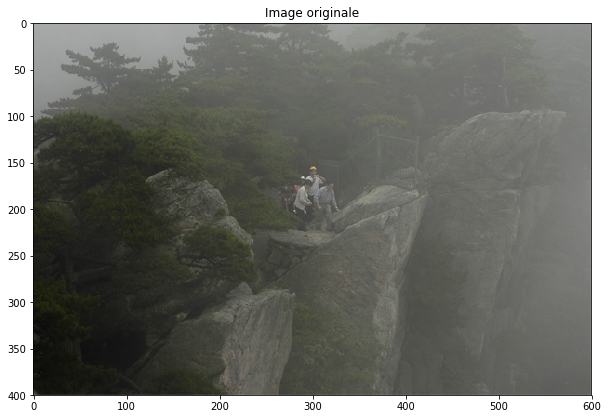

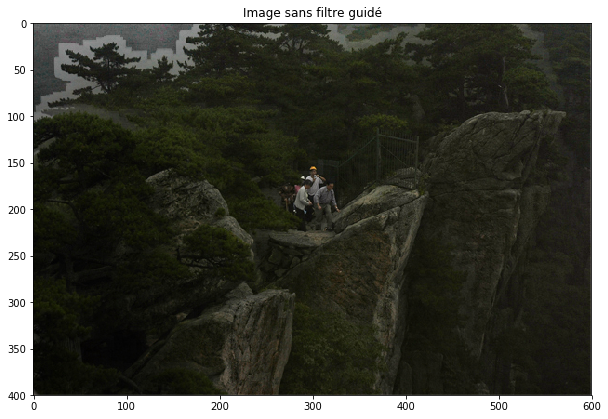

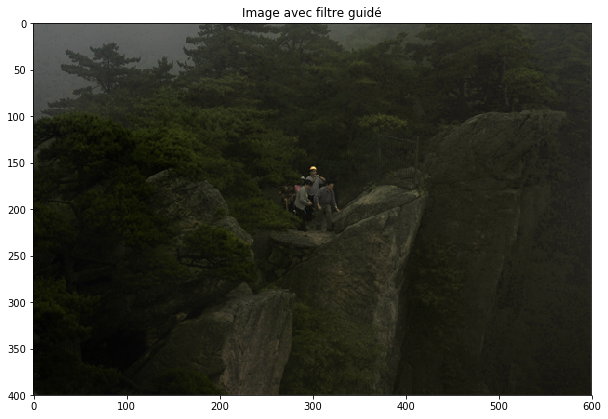

35.60229778289795


In [24]:
haze_removal("mountain",100,0.5,0.95)